# NBA Shot Visualization

Inspired by: [NBA Shot Chart - Python & Tableau](https://medium.com/@cristianvaldez85/nba-shot-chart-python-tableau-2f020b814c5a)

In this notebook, we'll explore how data visualization can be used to analyze NBA shot attempts by overlaying shot data onto a basketball court. This technique helps reveal shooting patterns, player tendencies, and overall team performance in a visually intuitive way.

We’ll leverage an **NBA API** (*more on APIs to come*) to retrieve real-time statistics on games, players, and teams, allowing us to create insightful and dynamic shot charts. This is a great example of how effective visualizations can transform raw data into compelling, story-driven insights.

As always, let's start by importing the required libraries.

In [1]:
# TODO: If `nba_api` is not installed in your environment, uncomment the line below.
# !pip install nba_api

from nba_api.stats.endpoints import shotchartdetail
import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

## Obtaining `teamId`
Before we leverage the NBA API, let's load some metadata for the **30 active NBA teams** from a [publicly available JSON file hosted on GitHub](https://github.com/bttmly/nba/blob/master/data/teams.json). This JSON contains key information, including `teamId`, which is a required parameter for making requests to the NBA API (as you'll see in the coming section).

In [2]:
# Load teams JSON
teams = json.loads(requests.get("https://raw.githubusercontent.com/bttmly/nba/master/data/teams.json").text)

# Inspect the data type and total entries
print(f"`teams` is a {type(teams)} with {len(teams)} entries")

`teams` is a <class 'list'> with 30 entries


Here's an example of the first 5 entries:

In [3]:
# Inspect the first 5 entries
teams[:5]

[{'teamId': 1610612737,
  'abbreviation': 'ATL',
  'teamName': 'Atlanta Hawks',
  'simpleName': 'Hawks',
  'location': 'Atlanta'},
 {'teamId': 1610612738,
  'abbreviation': 'BOS',
  'teamName': 'Boston Celtics',
  'simpleName': 'Celtics',
  'location': 'Boston'},
 {'teamId': 1610612751,
  'abbreviation': 'BKN',
  'teamName': 'Brooklyn Nets',
  'simpleName': 'Nets',
  'location': 'Brooklyn'},
 {'teamId': 1610612766,
  'abbreviation': 'CHA',
  'teamName': 'Charlotte Hornets',
  'simpleName': 'Hornets',
  'location': 'Charlotte'},
 {'teamId': 1610612741,
  'abbreviation': 'CHI',
  'teamName': 'Chicago Bulls',
  'simpleName': 'Bulls',
  'location': 'Chicago'}]

Now that we’ve loaded the team metadata, let’s extract and display the **team names** of all NBA teams. In the following loop, we iterate through `teams` and print the value of the `"teamName"` key.

In [4]:
for t in teams:
    print(t["teamName"])

Atlanta Hawks
Boston Celtics
Brooklyn Nets
Charlotte Hornets
Chicago Bulls
Cleveland Cavaliers
Dallas Mavericks
Denver Nuggets
Detroit Pistons
Golden State Warriors
Houston Rockets
Indiana Pacers
Los Angeles Clippers
Los Angeles Lakers
Memphis Grizzlies
Miami Heat
Milwaukee Bucks
Minnesota Timberwolves
New Orleans Pelicans
New York Knicks
Oklahoma City Thunder
Orlando Magic
Philadelphia 76ers
Phoenix Suns
Portland Trail Blazers
Sacramento Kings
San Antonio Spurs
Toronto Raptors
Utah Jazz
Washington Wizards


Since `teamId` is a required parameter for the **NBA API**, we need a way to look up the correct ID for a given team. Instead of manually searching through the JSON, we can use the function below to retrieve the `teamId` based on either the **full team name** (e.g., *"Los Angeles Lakers"*) or the **simple name** (e.g., *"Lakers"*).

In [5]:
# TODO: Notice the docstrings. Docstrings are a common industry standard for documenting functions.
def get_team_id(team_name: str = None, simple_name: str = None) -> int:
    """
    Retrieves the NBA team ID based on the provided team name or simple name.

    Parameters:
    -----------
    team_name : str, optional
        The full name of the NBA team (e.g., "Los Angeles Lakers").
    simple_name : str, optional
        The short/simple name of the NBA team (e.g., "Lakers").

    Returns:
    --------
    int
        The corresponding teamId if a match is found.

    Raises:
    -------
    ValueError
        If both `team_name` and `simple_name` are provided.
        If no matching team is found in the JSON.
    """
    if team_name and simple_name:
        raise ValueError("Provide either 'team_name' or 'simple_name', but not both.")
    elif team_name:
        for t in teams:
            if t["teamName"] == team_name:
                return t["teamId"]
        raise ValueError(f"Provided '{team_name}' does not exist.")
    elif simple_name:
        for t in teams:
            if t["simpleName"] == simple_name:
                return t["teamId"]
        raise ValueError(f"Provided '{simple_name}' does not exist.")

We can use our function, `get_team_id()` to easily extract the `teamId` for a given team by specifying the `team_name`,

In [6]:
# TODO: Try the following and observe the output,
#    - Providing a value for both `team_name` and `simple_name`
#    - Providing a nonexistent value for `team_name`
#    - Providing a nonexistent value for `simple_name`
get_team_id(team_name="Los Angeles Lakers")

1610612747

Alternatively, we'll get the same result by specifying the `simple_name`,

In [7]:
get_team_id(simple_name="Lakers")

1610612747

## Obtaining `playerId`
Now that we've established how to retrieve `teamId` values, we need to do the same for players. The NBA API also requires a `playerId` parameter to fetch shot attempt data for specific athletes.

To obtain this, we'll use another [publicly available JSON file hosted on GitHub](https://github.com/bttmly/nba/blob/master/data/players.json), which contains metadata for NBA players, including their **team affiliation** (`teamId`) and **unique player identifier** (`playerId`).

Let's load and inspect this dataset:

In [8]:
players = json.loads(requests.get("https://raw.githubusercontent.com/bttmly/nba/master/data/players.json").text)

# Inspect the data type and total entries
print(f"`players` is a {type(players)} with {len(players)} entries")

`players` is a <class 'list'> with 545 entries


Here's an example of the first 5 entries:

In [9]:
players[:5]

[{'firstName': 'Precious',
  'lastName': 'Achiuwa',
  'playerId': 1630173,
  'teamId': 1610612748},
 {'firstName': 'Jaylen',
  'lastName': 'Adams',
  'playerId': 1629121,
  'teamId': 0},
 {'firstName': 'Steven',
  'lastName': 'Adams',
  'playerId': 203500,
  'teamId': 1610612740},
 {'firstName': 'Bam',
  'lastName': 'Adebayo',
  'playerId': 1628389,
  'teamId': 1610612748},
 {'firstName': 'LaMarcus',
  'lastName': 'Aldridge',
  'playerId': 200746,
  'teamId': 0}]

Just like we did for `teamId`, we’ll create a helper function called `get_player_id()`, which takes a player's first and last name as input and returns their corresponding `playerId`. This will allow us to dynamically retrieve the `playerId` for any player in the JSON.

In [10]:
def get_player_id(first_name: str, last_name: str) -> int:
    """
    Retrieves the NBA player ID based on the provided first and last name.

    Parameters:
    -----------
    first_name : str
        The first name of the NBA player.
    last_name : str
        The last name of the NBA player.

    Returns:
    --------
    int
        The corresponding playerId if a match is found.

    Raises:
    -------
    ValueError
        If no matching player is found in the dataset.
    """
    for p in players:
        if p["firstName"] == first_name and p["lastName"] == last_name:
            return p["playerId"]
    raise ValueError(f"Provided '{first_name} {last_name}' does not exist.")

Let’s now see the function in action:

In [11]:
get_player_id(first_name="LeBron", last_name="James")

2544

## Send a request to the NBA API
Now that we have the necessary helper functions and metadata, let’s send a request to the NBA API to retrieve shot data for **Stephen Curry** during his incredible MVP season with the **Golden State Warriors** in **2015-2016**.

We'll use the `ShotChartDetail` function from the NBA API to get detailed shot data for a given player, team, and season.

In [12]:
# Send request to NBA API to get shot data for Stephen Curry in the 2015-2016 season
made_shots_json = shotchartdetail.ShotChartDetail(
    team_id=get_team_id(team_name="Golden State Warriors"),       # Team ID for Golden State Warriors
    player_id=get_player_id(first_name="Stephen", last_name="Curry"),  # Player ID for Stephen Curry
    context_measure_simple="PTS",  # Measure to use (PTS for made shots)
    season_nullable="2015-16",  # Season of interest (2015–16)
    season_type_all_star="Regular Season",  # Type of season (Regular Season)
)
made_shots_json

### Explanation of Key Parameters:
Here’s what each of the arguments means:
- `context_measure_simple`: This specifies the context for the shot data. By default, it's set to `"PTS"`, which will return all made shots. If you wanted to include all shot attempts (made and missed), you could use `"FGA"` (Field Goals Attempted).

- `season_nullable`: The season you are interested in. For this example, we're pulling data from the **2015-16 season**.

- `season_type_all_star`: Specifies the portion of the season you're focusing on. In this case, we're querying the **Regular Season** data. Other options include **Pre Season**, **Playoffs**, and **All Star**.

### References:
- [NBA API Documentation](https://github.com/swar/nba_api)

- [ShotChartDetail Function Documentation](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md)

Here, let's use the `"FGA"` code and get missed attempts as well as successful attempts.  

In [13]:
all_shots_json = shotchartdetail.ShotChartDetail(
    team_id=get_team_id(team_name="Golden State Warriors"),       # Team ID for Golden State Warriors
    player_id=get_player_id(first_name="Stephen", last_name="Curry"),  # Player ID for Stephen Curry
    context_measure_simple="FGA",  # Measure to use (FGA for all shot attempts, made and missed)
    season_nullable="2015-16",  # Season of interest (2015–16)
    season_type_all_star="Regular Season",  # Type of season (Regular Season)
)

## Wrangling the Shot Data
Now that we have the raw shot data in JSON format, we need to load it into a Python dictionary so we can manipulate it.

In [14]:
# Load the raw shot data into a Python dictionary
made_shots_data = json.loads(made_shots_json.get_json())

# TODO: Uncomment the following line to inspect the output
# made_shots_data

The `made_shots_data` dictionary contains a lot of information, but we only need the relevant shot data. This can be found under the `resultSets` key, which is an array. We need to extract the first element of this array to access the data we need.

In [15]:
# Extract the relevant data from the resultSets array
made_shots_relevant_data = made_shots_data["resultSets"][0]

You can inspect the structure of the `made_shots_relevant_data` to better understand what it contains.

In [16]:
# TODO: Uncomment the following line to inspect the output
# made_shots_relevant_data

The `made_shots_relevant_data` dictionary contains two important pieces of information:
- `headers`: The column names for the shot data.
  
- `rowSet`: The actual shot data, where each row corresponds to a shot attempt.

In [17]:
# Extract the headers and row data
made_shots_headers = made_shots_relevant_data["headers"]
made_shots_rows = made_shots_relevant_data["rowSet"]

You can inspect the headers to see what each column represents.

In [18]:
made_shots_headers

['GRID_TYPE',
 'GAME_ID',
 'GAME_EVENT_ID',
 'PLAYER_ID',
 'PLAYER_NAME',
 'TEAM_ID',
 'TEAM_NAME',
 'PERIOD',
 'MINUTES_REMAINING',
 'SECONDS_REMAINING',
 'EVENT_TYPE',
 'ACTION_TYPE',
 'SHOT_TYPE',
 'SHOT_ZONE_BASIC',
 'SHOT_ZONE_AREA',
 'SHOT_ZONE_RANGE',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'SHOT_ATTEMPTED_FLAG',
 'SHOT_MADE_FLAG',
 'GAME_DATE',
 'HTM',
 'VTM']

Next, inspect a sample of the row data to understand the format.

In [19]:
made_shots_rows[0]

['Shot Chart Detail',
 '0021500003',
 6,
 201939,
 'Stephen Curry',
 1610612744,
 'Golden State Warriors',
 1,
 10,
 56,
 'Made Shot',
 'Cutting Finger Roll Layup Shot',
 '2PT Field Goal',
 'Restricted Area',
 'Center(C)',
 'Less Than 8 ft.',
 3,
 12,
 31,
 1,
 1,
 '20151027',
 'GSW',
 'NOP']

Now, we’ll repeat the same process to extract the shot data for **all attempts** (both successful and missed). This time, we use the `all_shots_json` object we created earlier.

In [20]:
# Load data for all shots (made and missed)
all_shots_data = json.loads(all_shots_json.get_json())

# Extract the relevant data
all_shots_relevant_data = all_shots_data["resultSets"][0]
all_shots_headers = all_shots_relevant_data["headers"]
all_shots_rows = all_shots_relevant_data["rowSet"]

## Create Pandas DataFrame for Analysis

Now that we have the data for all shots, we can convert it into a pandas DataFrame for easier manipulation and analysis.

### Stephen Curry (Only Made Shots)
First, let’s create a DataFrame for only the **successful shots** (the original blog used this method).

In [21]:
made_shots_df = pd.DataFrame(made_shots_rows)
made_shots_df.columns = made_shots_headers

You can inspect the columns to confirm that the headers have been correctly assigned.

In [22]:
made_shots_df.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

Finally, let’s take a look at the DataFrame.

In [23]:
made_shots_df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021500003,6,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,56,...,Center(C),Less Than 8 ft.,3,12,31,1,1,20151027,GSW,NOP
1,Shot Chart Detail,0021500003,19,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,13,...,Left Side Center(LC),24+ ft.,27,-197,193,1,1,20151027,GSW,NOP
2,Shot Chart Detail,0021500003,36,201939,Stephen Curry,1610612744,Golden State Warriors,1,7,11,...,Center(C),Less Than 8 ft.,0,-4,8,1,1,20151027,GSW,NOP
3,Shot Chart Detail,0021500003,38,201939,Stephen Curry,1610612744,Golden State Warriors,1,6,45,...,Center(C),24+ ft.,25,-11,259,1,1,20151027,GSW,NOP
4,Shot Chart Detail,0021500003,46,201939,Stephen Curry,1610612744,Golden State Warriors,1,5,50,...,Left Side Center(LC),16-24 ft.,22,-117,188,1,1,20151027,GSW,NOP


We can also inspect the shape to determine the total shots Curry made during the 2015-2016 season.

In [24]:
# Based on the output, Curry made 804 successful shots during the 2015-2016 season
made_shots_df.shape

(804, 24)

### Stephen Curry (All Shot Attempts - Made and Missed)
Next, we create a DataFrame for **all shots** (both made and missed). Notice that the `SHOT_MADE_FLAG` column contains both `1`s (for made shots) and `0`s (for missed shots).

In [25]:
all_shots_df = pd.DataFrame(all_shots_rows)
all_shots_df.columns = all_shots_headers
all_shots_df

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021500003,6,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,56,...,Center(C),Less Than 8 ft.,3,12,31,1,1,20151027,GSW,NOP
1,Shot Chart Detail,0021500003,9,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,29,...,Left Side Center(LC),24+ ft.,26,-176,195,1,0,20151027,GSW,NOP
2,Shot Chart Detail,0021500003,14,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,34,...,Center(C),Less Than 8 ft.,2,20,9,1,0,20151027,GSW,NOP
3,Shot Chart Detail,0021500003,19,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,13,...,Left Side Center(LC),24+ ft.,27,-197,193,1,1,20151027,GSW,NOP
4,Shot Chart Detail,0021500003,36,201939,Stephen Curry,1610612744,Golden State Warriors,1,7,11,...,Center(C),Less Than 8 ft.,0,-4,8,1,1,20151027,GSW,NOP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,Shot Chart Detail,0021501227,322,201939,Stephen Curry,1610612744,Golden State Warriors,3,5,43,...,Center(C),Less Than 8 ft.,2,20,16,1,1,20160413,GSW,MEM
1592,Shot Chart Detail,0021501227,350,201939,Stephen Curry,1610612744,Golden State Warriors,3,2,43,...,Center(C),24+ ft.,30,4,303,1,0,20160413,GSW,MEM
1593,Shot Chart Detail,0021501227,364,201939,Stephen Curry,1610612744,Golden State Warriors,3,1,27,...,Center(C),Less Than 8 ft.,2,10,21,1,1,20160413,GSW,MEM
1594,Shot Chart Detail,0021501227,372,201939,Stephen Curry,1610612744,Golden State Warriors,3,0,32,...,Right Side Center(RC),24+ ft.,27,209,183,1,0,20160413,GSW,MEM


And this DataFrame will contain more rows (1596) compared to the one for only made shots (804).

In [26]:
all_shots_df.shape

(1596, 24)

Now we have the data we need. We have two DataFrames:
1. `made_shots_df` — Contains only successful shots.
   
2. `all_shots_df` — Contains all shot attempts (both made and missed).

With this data, we can move on to visualizing Stephen Curry's shooting performance in the 2015-2016 season!

---
## Visualizing Shot Locations on a Basketball Court
Now, we'll visualize Stephen Curry's successful and missed shots on an NBA court overlay. The coordinates for the shot attempts are stored in the `LOC_X` and `LOC_Y` columns of the DataFrame, which we will use to plot the shots on the court.

### Inspect the Shot Coordinates
The `LOC_X` and `LOC_Y` columns in our dataset represent the shot locations in 1/10th of a foot, so we need to inspect their range to understand the scale of the data.

- `LOC_X` (horizontal) coordinates range from **-245 to 240**.

- `LOC_Y` (vertical) coordinates range from **-21 to 712**.

In [27]:
# Printing the range of LOC_X (the min and max)
print((all_shots_df["LOC_X"].min(), all_shots_df["LOC_X"].max()))

# Printing the range of LOC_Y (the min and max)
print((all_shots_df["LOC_Y"].min(), all_shots_df["LOC_Y"].max()))

(-245, 240)
(-21, 712)


We will use these ranges to accurately position the shot locations on an overlay of an NBA court.

### Create a Basketball Court
Before plotting the shot data, let's first create a basketball court figure. This includes key elements like the **3-point line**, **lane**, **key**, **rim**, and **backboard**.

Here’s the code to draw the court using `matplotlib`:

In [28]:
# Function to draw basketball court
def create_court(ax, color):
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    
    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2)) 
    
    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)

Here is the original court template.

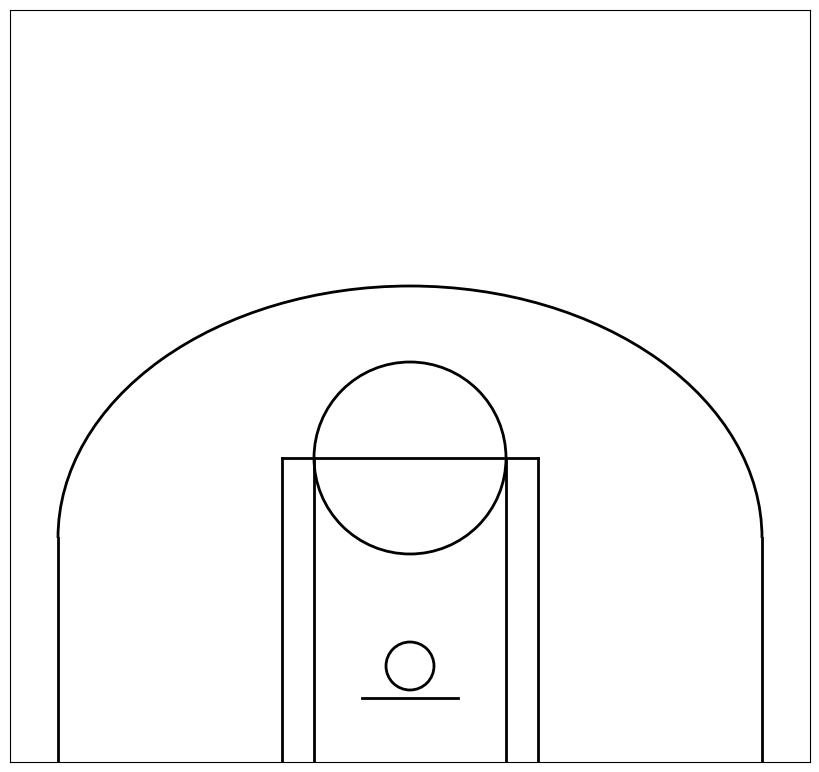

In [29]:
fig = plt.figure(figsize=(8, 7.52))

ax = fig.add_axes([0, 0, 1, 1])
ax = create_court(ax, "black")

# TODO: Uncomment the following line to save the image as a PNG template
# plt.savefig("../images/basketball_halfcourt.png")

plt.show()

### Draw the Court and Plot Shot Data
Now that we have the function to draw the court, let's create the court figure and overlay the shot data. We will plot the successful shots (made shots) using a **hexbin plot** and the full shot data (both made and missed shots) with a **scatter plot**.

#### Hexbin Plot (for Successful Shots Only)
The **hexbin plot** groups nearby shot locations into hexagonal bins and visualizes their frequency with color intensity.

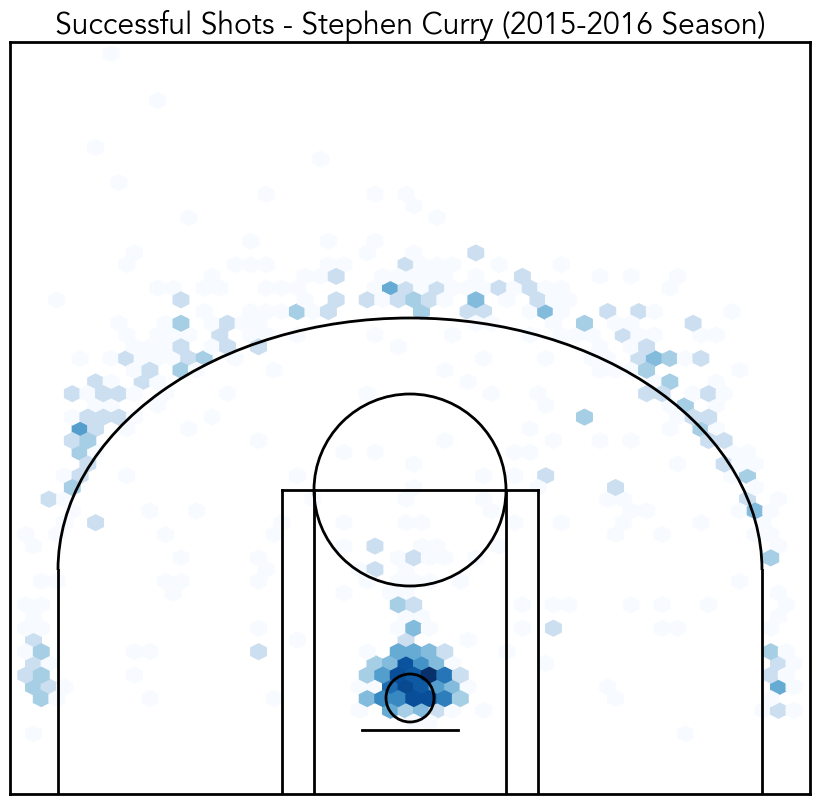

In [30]:
# General plot parameters
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2

# Create the figure
fig = plt.figure(figsize=(8, 7.52))
ax = fig.add_axes([0, 0, 1, 1])

# Plot hexbin of successful shots first (below the court)
plt.hexbin(made_shots_df['LOC_X'], made_shots_df['LOC_Y'] + 60, gridsize=(50, 50), extent=(-245, 240, -21, 712), bins='log', cmap='Blues')

# Now draw the court on top of the hexbin
ax = create_court(ax, 'black')

# Title and display
plt.title('Successful Shots - Stephen Curry (2015-2016 Season)')
plt.show()

#### Scatter Plot (for All Shots)
Next, we will plot all shot attempts (both made and missed) as a scatter plot. The `SHOT_MADE_FLAG` column indicates whether the shot was made (`1`) or missed (`0`), so we’ll color the points accordingly.

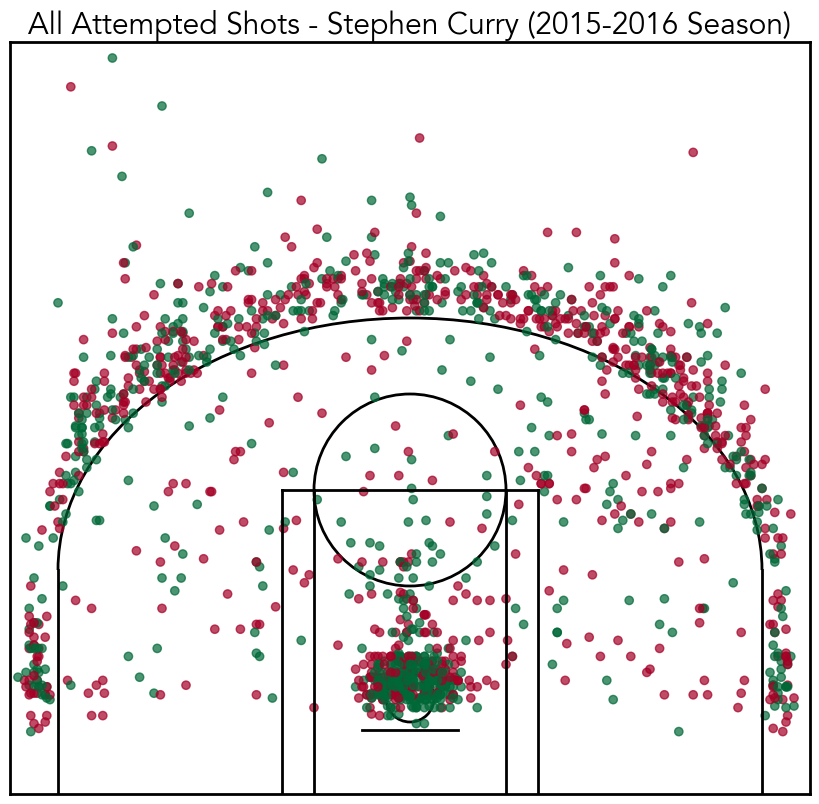

In [31]:
fig = plt.figure(figsize=(8, 7.52))
ax = fig.add_axes([0, 0, 1, 1])
ax = create_court(ax, 'black')

plt.scatter(all_shots_df['LOC_X'], all_shots_df['LOC_Y']+60, c=all_shots_df['SHOT_MADE_FLAG'], cmap='RdYlGn', alpha=0.7)

# TODO: Comment the prior plt.scatter() call and uncomment the following line to plot made shots only
# plt.scatter(made_shots_df['LOC_X'], made_shots_df['LOC_Y']+60, c='k', alpha=0.9)

plt.title('All Attempted Shots - Stephen Curry (2015-2016 Season)')

plt.show()

## Conclusion
In this notebook, we demonstrated how effective visualizations can transform raw data into compelling, story-driven insights. Specifically, we:

1. Created a basketball court figure as a foundation for visualizing shot data.

2. Plotted successful shots using a hexbin plot, revealing the areas where Stephen Curry was most effective.

3. Used a scatter plot to visualize all shot attempts, differentiating between made and missed shots.

This visualization allows us to explore **Stephen Curry's shot distribution** on the court, which can provide valuable insights into his shooting patterns and tendencies during the 2015-2016 season. This example highlights the effectiveness of data visualization—not just to present numbers, but to tell a story that provides deeper understanding and guides decision-making.